# Data preparation and cleaning

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#from matplotlib.collections import LineCollection
from sklearn import manifold, preprocessing
#from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

from scipy import stats

Total number of responses from qualtrics - 721


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Number of cells containing data - 25
maximum number of subjects rating - 127
minimum number of subjects rating - 80
Total number of responses, excluding bad participants - 592


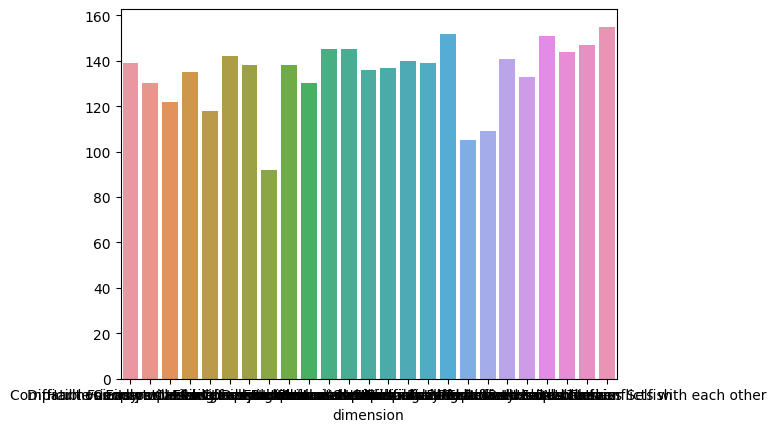

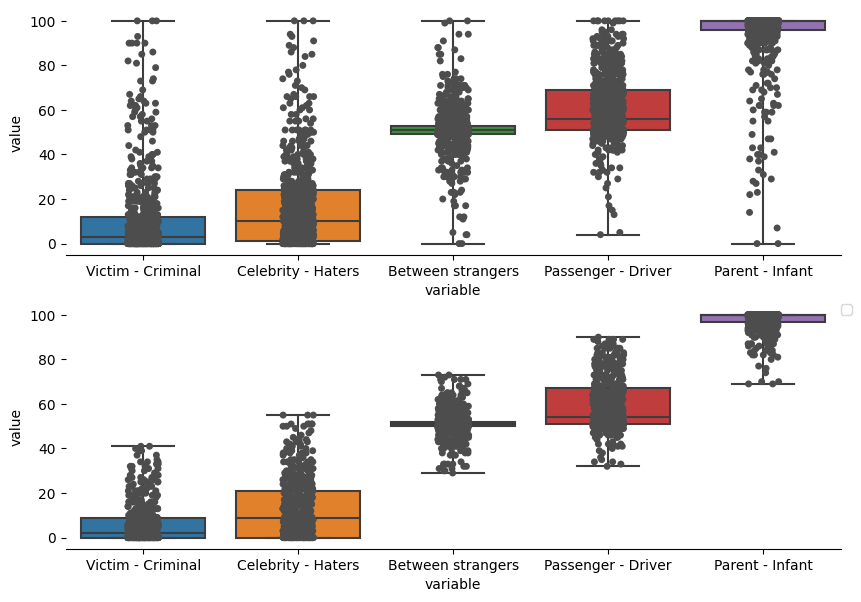

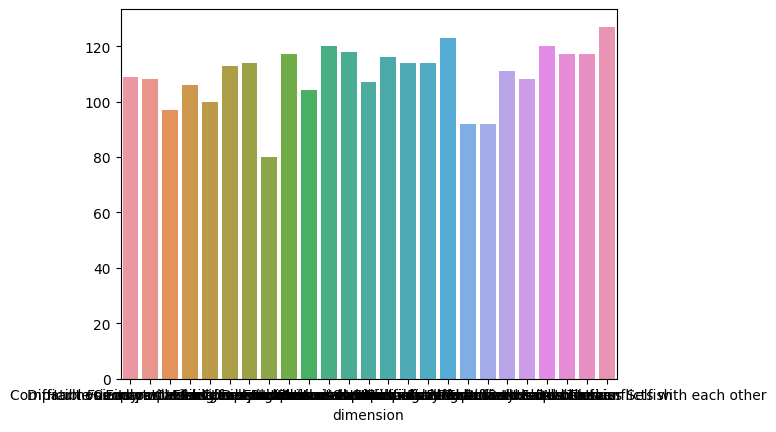

In [4]:
# Prep responses and key
raw = pd.read_csv('wish_replication/input_data/RK - Wish Replication - Version 1_March 15, 2019_12.49.csv')
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])
key = pd.read_csv('wish_replication/input_data/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q8.1')]
relationships = [s.replace('\xe2\x80\x93', '-') for s in relationships]
relationships = [x[7:] for x in relationships]
dimension_frames = {}
count=0
for dim in key['dimension'].tolist()[:-2]:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q'+str(key['block'].iloc[count])+'.1')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])
    dimension_frames[dim].columns = relationships
    # Delete all data for "between cousins" and only keep "second cousins"
    dimension_frames[dim]['Between second cousins'].iloc[:629] = np.nan
    count=count+1

    
    
    
num_response = []
for col in dimension_frames['Active vs Inactive'].columns:
    num_response.append(dimension_frames['Active vs Inactive'][col].count())
plt.figure()
sns.barplot(x=key['dimension'].iloc[:25],y=num_response)


# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q37')]
foil_relationships = [x[6:] for x in foil_relationships]
filtered_cols = [col for col in raw_reorg if col.startswith('Q37')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['MTurkCode']  =raw_reorg['MTurkCode']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='MTurkCode')

# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > 
                   foils[rel].mean()+foils[rel].std()*2) |
                   (foils[rel] < 
                    foils[rel].mean()-foils[rel].std()*2)].index)
outliers_list = set(outliers_list)



# Remove outliers based on assumptions of words
# Frequency of deathbed > car
# Removing subjects based on completetion time is not the best (they do okay)
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='MTurkCode')


f, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)


# Remove outliers from the rest of the data
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)
    
    
# Check total number of responses for each word with outliers excluded
num_response = []
for col in dimension_frames_outliers['Active vs Inactive'].columns:
    num_response.append(dimension_frames_outliers['Active vs Inactive'][col].count())
plt.figure()
sns.barplot(x=key['dimension'].iloc[:25],y=num_response)

#print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers['Active vs Inactive'])))




dimensions = key['dimension'].iloc[:25]
dimensions = dimensions.to_list()

num_response_afterDK_count =  pd.DataFrame(columns=relationships)
count = 0
for dim in dimensions: 
    num_response_afterDK_count.loc[count] = [dimension_frames_outliers[dim][col].count() for col in dimension_frames_outliers[dim].columns]
    count += 1 
num_response_afterDK_count.index = dimensions

# check whether there is data in every cell
print("Number of cells containing data - " + str(num_response_afterDK_count.isnull().all().count())) 

print("maximum number of subjects rating - " + str(max(list(num_response_afterDK_count.max()))))
print("minimum number of subjects rating - " + str(min(list(num_response_afterDK_count.min()))))

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))

In [5]:
# Create a dataframe that has the average response for each relationship, on each dimension
dim_rel = pd.DataFrame(columns=relationships)
count=0
for dim in dimension_frames_outliers.keys():
    dim_rel.loc[count] = dimension_frames_outliers[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimension_frames_outliers.keys()
dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled_df = pd.DataFrame(dim_rel_scaled, index=dim_rel.columns,
                                 columns=dim_rel.index)

# Correlation: raw matrix

In [6]:
random_r_value_sub_all = pd.DataFrame(np.nan, columns = range(2,41), index=range(1,1001))
random_r_value_sub_ex = pd.DataFrame(np.nan, columns = range(2,41), index=range(1,1001))

dimensions = [i for i in dimension_frames_outliers.keys()]
output_dir = 'output_data/'
              
for num in range(2,41):
    for i in range(1,1001):
        dim_rel_subsample = pd.DataFrame(columns=relationships, index=dimensions)
        dim_rel_exsample = pd.DataFrame(columns=relationships, index=dimensions)
        
        for dim in dimensions: 
            mean_temp_sub = []
            mean_temp_ex = []
              
            for rel in relationships:
                cell_allsample = dimension_frames_outliers[dim][rel].dropna()#subjects who responded in each cell(1dimension * 1relationship)
                cell_subsample = cell_allsample.sample(n=num, random_state=i)#random sampling
                #exclude random sampling
                sub_index = list(cell_subsample.index)
                ex_index = cell_allsample.index[~cell_allsample.index.isin(sub_index)]
                cell_exsample = cell_allsample[ex_index]
                
                mean_temp_sub.append(cell_subsample.mean())#caculate the mean of subsample responding in this cell
                mean_temp_ex.append(cell_exsample.mean())#caculate the mean of exsample responding in this cell
              
            dim_rel_subsample.loc[dim,:] = mean_temp_sub
            dim_rel_exsample.loc[dim,:] = mean_temp_ex
            
        dim_rel_subsample_scaled = preprocessing.scale(dim_rel_subsample.transpose())#normalizing raw matrix(25*25)of subsample
        dim_rel_exsample_scaled = preprocessing.scale(dim_rel_exsample.transpose())#normalizing raw matrix(25*25)of exsample
              
        r_value_sub_all = stats.pearsonr(dim_rel_scaled.flatten(), dim_rel_subsample_scaled.flatten())[0]
        r_value_sub_ex = stats.pearsonr(dim_rel_exsample_scaled.flatten(), dim_rel_subsample_scaled.flatten())[0]

        random_r_value_sub_all.loc[i,num] = r_value_sub_all
        random_r_value_sub_ex.loc[i,num] = r_value_sub_ex      
        
        file_name = 'num_'+str(num)+'_random_step_'+str(i)
        dim_rel_subsample_scaled_df = pd.DataFrame(dim_rel_subsample_scaled, index=dim_rel_subsample.columns,columns=dim_rel_subsample.index)
        dim_rel_exsample_scaled_df = pd.DataFrame(dim_rel_exsample_scaled, index=dim_rel_exsample.columns,columns=dim_rel_exsample.index)
              
        dim_rel_subsample_scaled_df.to_csv(output_dir+'raw_matrix/subsample/'+file_name+'_sub.csv',encoding='gb18030')
        dim_rel_exsample_scaled_df.to_csv(output_dir+'raw_matrix/exsample/'+file_name+'_ex.csv',encoding='gb18030')
        
random_r_value_sub_all.to_csv(output_dir+'correlation_result/raw_matrix_r_value_sub_all.csv')
random_r_value_sub_ex.to_csv(output_dir+'correlation_result/raw_matrix_r_value_sub_ex.csv')

# Correlation: PCA

In [2]:
library(FactoMineR)
library(factoextra)
library(psych)
library(ggplot2)
library(reshape)
library(cowplot)
library(stringr)
library(corrplot)
library(plyr)
library(Rmisc)
library(tidyverse)
library(dplyr)

In [8]:
dim_rel_scaled = read.csv('wish_replication/output_data/dim_rel_scaled.csv', row.names=1, encoding = "UTF-8")

ncomp = 4 # specify num of PC
pca_allsample = prcomp(dim_rel_scaled)

#get the components defined by loadings and scores with / without varimax
pca_allsample_loadings = pca_allsample$rotation[,1:ncomp]
pca_allsample_scores = pca_allsample$x[,1:ncomp]

#rotate_varimax
rawLoadings = pca_allsample$rotation[,1:ncomp] %*% diag(pca_allsample$sdev, ncomp, ncomp)
## Get the raw loadings (i.e without varimax rotation) by multiple $rotation with $sdev

# Rotate the raw loadings
pca_allsample_loadings_var <- varimax(rawLoadings)$loadings#how to transform into matrix

# Multiple the scores matrix with varimax matrix:
pca_allsample_scores_var <- scale(pca_allsample$x[,1:ncomp]) %*% varimax(rawLoadings)$rotmat
# Scores computed via rotating the scores

In [13]:
cor_r_value_sub_all_scores = matrix(nrow=1000,ncol=39)
#cor_r_value_sub_ex_scores = matrix(nrow=1000,ncol=39)
cor_r_value_sub_all_loadings = matrix(nrow=1000,ncol=39)
#cor_r_value_sub_ex_loadings = matrix(nrow=1000,ncol=39)

#cor_r_value_sub_all_scores_var = matrix(nrow=1000,ncol=39)
#cor_r_value_sub_ex_scores_var = matrix(nrow=1000,ncol=39)
#cor_r_value_sub_all_loadings_var = matrix(nrow=1000,ncol=39)
#cor_r_value_sub_ex_loadings_var = matrix(nrow=1000,ncol=39)

#pca_subsample_ncomp = matrix(nrow=1000,ncol=39)
#pca_exsample_ncomp = matrix(nrow=1000,ncol=39)

for (num in seq(2,40)){
  for (i in seq(1,1000)) {
    ###1.pca_subsample
    dim_rel_subsample_scaled = read.csv(paste('output_data/raw_matrix/subsample/num_',num,'_random_step_',i,'_sub.csv',sep=''), row.names=1)
      
    ##1.1 Parallel analysis suggests that the number of components
    #ncomp_temp_sub = fa.parallel(dim_rel_subsample_scaled,fa='pc',plot=FALSE)$ncomp
    #pca_subsample_ncomp[i,num-1] = ncomp_temp_sub
    
    ncomp = 4 # specify num of PC
    pca_subsample = prcomp(dim_rel_subsample_scaled) 
      
    ##1.2 components defined by loadings and scores with / withour varimax
    pca_subsample_loadings = pca_subsample$rotation[,1:ncomp]
    pca_subsample_scores = pca_subsample$x[,1:ncomp]
      
    write.csv(pca_subsample_loadings,
    paste('output_data/pca_matrix/loading_score/',num,'_random_step_',i,'_sub.csv',sep=''))
    write.csv(pca_subsample_scores,
    paste('output_data/pca_matrix/relationships_score/',num,'_random_step_',i,'_sub.csv',sep=''))

    #rotate_varimax
    #rawLoadings = pca_subsample$rotation[,1:ncomp] %*% diag(pca_subsample$sdev, ncomp, ncomp)
    #Get the raw loadings (i.e without varimax rotation) by multiple $rotation with $sdev

    #Rotate the raw loadings
    #pca_subsample_loadings_var <- varimax(rawLoadings)$loadings#how to transform into matrix

    #Multiple the scores matrix with varimax matrix:
    #pca_subsample_scores_var <- scale(pca_subsample$x[,1:ncomp]) %*% varimax(rawLoadings)$rotmat
    #Scores computed via rotating the scores
  

    
    ###2.pca_exsample
    #dim_rel_exsample_scaled = read.csv(paste('output_data/raw_matrix/exsample/num_',num,'_random_step_',i,'_ex.csv',sep=''), row.names=1)
      
    ##2.1 Parallel analysis suggests that the number of components  
    #ncomp_temp_ex = fa.parallel(dim_rel_exsample_scaled,fa='pc',plot=FALSE)$ncomp
    #pca_exsample_ncomp[i,num-1] = ncomp_temp_ex

    #ncomp = 4 # specify num of PC
    #pca_exsample = prcomp(dim_rel_exsample_scaled)
      
    ##2.2 components defined by loadings and scores with / withour varimax
    #pca_exsample_loadings = pca_exsample$rotation[,1:ncomp]
    #pca_exsample_scores = pca_exsample$x[,1:ncomp]

    #rotate_varimax
    #rawLoadings = pca_exsample$rotation[,1:ncomp] %*% diag(pca_exsample$sdev, ncomp, ncomp)
    #Get the raw loadings (i.e without varimax rotation) by multiple $rotation with $sdev

    #Rotate the raw loadings
    #pca_exsample_loadings_var <- varimax(rawLoadings)$loadings#how to transform into matrix

    #Multiple the scores matrix with varimax matrix:
    #pca_exsample_scores_var <- scale(pca_exsample$x[,1:ncomp]) %*% varimax(rawLoadings)$rotmat
    #Scores computed via rotating the scores      
                

      
    ###output: r_value_scores
    #none  
    cor_sub_all_scores = corr.test(as.vector(abs(pca_allsample_scores)),
                                   as.vector(abs(pca_subsample_scores)))
    r_value_sub_all_scores = cor_sub_all_scores$r
    #cor_sub_ex_scores = corr.test(as.vector(abs(pca_exsample_scores)),as.vector(abs(pca_subsample_scores)))
    #r_value_sub_ex_scores = cor_sub_ex_scores$r
    
    cor_r_value_sub_all_scores[i,num-1]=r_value_sub_all_scores
    #cor_r_value_sub_ex_scores[i,num-1]=r_value_sub_ex_scores
    
    #var  
    #cor_sub_all_scores_var = corr.test(as.vector(pca_allsample_scores_var),as.vector(pca_subsample_scores_var))
    #r_value_sub_all_scores_var = cor_sub_all_scores_var$r
    #cor_sub_ex_scores_var = corr.test(as.vector(pca_exsample_scores_var),as.vector(pca_subsample_scores_var))
    #r_value_sub_ex_scores_var = cor_sub_ex_scores_var$r
    
    #cor_r_value_sub_all_scores_var[i,num-1]=r_value_sub_all_scores_var
    #cor_r_value_sub_ex_scores_var[i,num-1]=r_value_sub_ex_scores_var
    
    ###output: r_value_loadings
    #none  
    cor_sub_all_loadings = corr.test(as.vector(abs(pca_allsample_loadings)),
                                     as.vector(abs(pca_subsample_loadings)))
    r_value_sub_all_loadings = cor_sub_all_loadings$r
    #cor_sub_ex_loadings = corr.test(as.vector(abs(pca_exsample_loadings)),as.vector(abs(pca_subsample_loadings)))
    #r_value_sub_ex_loadings = cor_sub_ex_loadings$r
    
    cor_r_value_sub_all_loadings[i,num-1]=r_value_sub_all_loadings
    #cor_r_value_sub_ex_loadings[i,num-1]=r_value_sub_ex_loadings
    
    #var
    #cor_sub_all_loadings_var = corr.test(as.vector(pca_allsample_loadings_var),as.vector(pca_subsample_loadings_var))
    #r_value_sub_all_loadings_var = cor_sub_all_loadings_var$r
    #cor_sub_ex_loadings_var = corr.test(as.vector(pca_exsample_loadings_var),as.vector(pca_subsample_loadings_var))
    #r_value_sub_ex_loadings_var = cor_sub_ex_loadings_var$r
    
    #cor_r_value_sub_all_loadings_var[i,num-1]=r_value_sub_all_loadings_var
    #cor_r_value_sub_ex_loadings_var[i,num-1]=r_value_sub_ex_loadings_var      
  }
}

cor_r_value_sub_all_scores = data.frame(cor_r_value_sub_all_scores)
#cor_r_value_sub_ex_scores = data.frame(cor_r_value_sub_ex_scores)
cor_r_value_sub_all_loadings = data.frame(cor_r_value_sub_all_loadings)
#cor_r_value_sub_ex_loadings = data.frame(cor_r_value_sub_ex_loadings)

#cor_r_value_sub_all_scores_var = data.frame(cor_r_value_sub_all_scores_var)
#cor_r_value_sub_ex_scores_var = data.frame(cor_r_value_sub_ex_scores_var)
#cor_r_value_sub_all_loadings_var = data.frame(cor_r_value_sub_all_loadings_var)
#cor_r_value_sub_ex_loadings_var = data.frame(cor_r_value_sub_ex_loadings_var)

#pca_subsample_ncomp = data.frame(pca_subsample_ncomp)
#pca_exsample_ncomp = data.frame(pca_exsample_ncomp)


write.csv(cor_r_value_sub_all_scores, file = 'output_data/correlation_result/pca_socres_sub_all_r_value.csv')
#write.csv(cor_r_value_sub_ex_scores, file = 'output_data/correlation_result/pca_socres_sub_ex_r_value.csv')
write.csv(cor_r_value_sub_all_loadings, file = 'output_data/correlation_result/pca_loadings_sub_all_r_value.csv')
#write.csv(cor_r_value_sub_ex_loadings, file = 'output_data/correlation_result/pca_loadings_sub_ex_r_value.csv')

#write.csv(cor_r_value_sub_all_scores_var, file = 'correlation_result/pca_socres_sub_all_r_value_var.csv')
#write.csv(cor_r_value_sub_ex_scores_var, file = 'correlation_result/pca_socres_sub_ex_r_value_var.csv')
#write.csv(cor_r_value_sub_all_loadings_var, file = 'correlation_result/pca_loadings_sub_all_r_value_var.csv')
#write.csv(cor_r_value_sub_ex_loadings_var, file = 'correlation_result/pca_loadings_sub_ex_r_value_var.csv')

#write.csv(pca_subsample_ncomp, file = 'output_data/correlation_result/pca_subsample_ncomp.csv')
#write.csv(pca_exsample_ncomp, file = 'output_data/correlation_result/pca_exsample_ncomp.csv')

# Plot results

In [3]:
raw_data_corr = read.csv('output_data/correlation_result/raw_matrix_r_value_sub_all.csv',
                         row.names=1)
raw_data_mean_std_df = data.frame(mean = apply(raw_data_corr,2,mean),
                       std = apply(raw_data_corr,2,sd))

In [4]:
# 1.raw data
raw_data_corr = read.csv('output_data/correlation_result/raw_matrix_r_value_sub_all.csv',row.names=1)
raw_data_mean_std_df = data.frame(mean = apply(raw_data_corr,2,mean),
                       std = apply(raw_data_corr,2,sd))

#raw_data_corr_melt = melt(raw_data_corr)
raw_data_mean_std_df$'step' = seq(2,40)
raw_data_mean_std_df$'data' = 'Raw rating score'

# 2.pca scores
pca_score_corr = read.csv('output_data/correlation_result/pca_socres_sub_all_r_value.csv',row.names=1)
pca_score_mean_std_df = data.frame(mean = apply(pca_score_corr,2,mean),
                         std = apply(pca_score_corr,2,sd))

pca_score_mean_std_df$'step' = seq(2,40)
pca_score_mean_std_df$'data' = 'PCA relationship score'

# 3.pca loadings
pca_loading_corr = read.csv('output_data/correlation_result/pca_loadings_sub_all_r_value.csv',row.names=1)
pca_loading_mean_std_df = data.frame(mean = apply(pca_loading_corr,2,mean),
                         std = apply(pca_loading_corr,2,sd))

pca_loading_mean_std_df$'step' = seq(2,40)
pca_loading_mean_std_df$'data' = 'PCA loading score'

# combine resutls
mean_std_df = rbind(raw_data_mean_std_df,pca_score_mean_std_df,pca_loading_mean_std_df)

In [5]:
mean_std_df %>% group_by(data) %>% filter(step == 10)

mean,std,step,data
<dbl>,<dbl>,<int>,<chr>
0.9543438,0.004632846,10,Raw rating score
0.9513830,0.013921002,10,PCA relationship score
0.9114720,0.044209255,10,PCA loading score


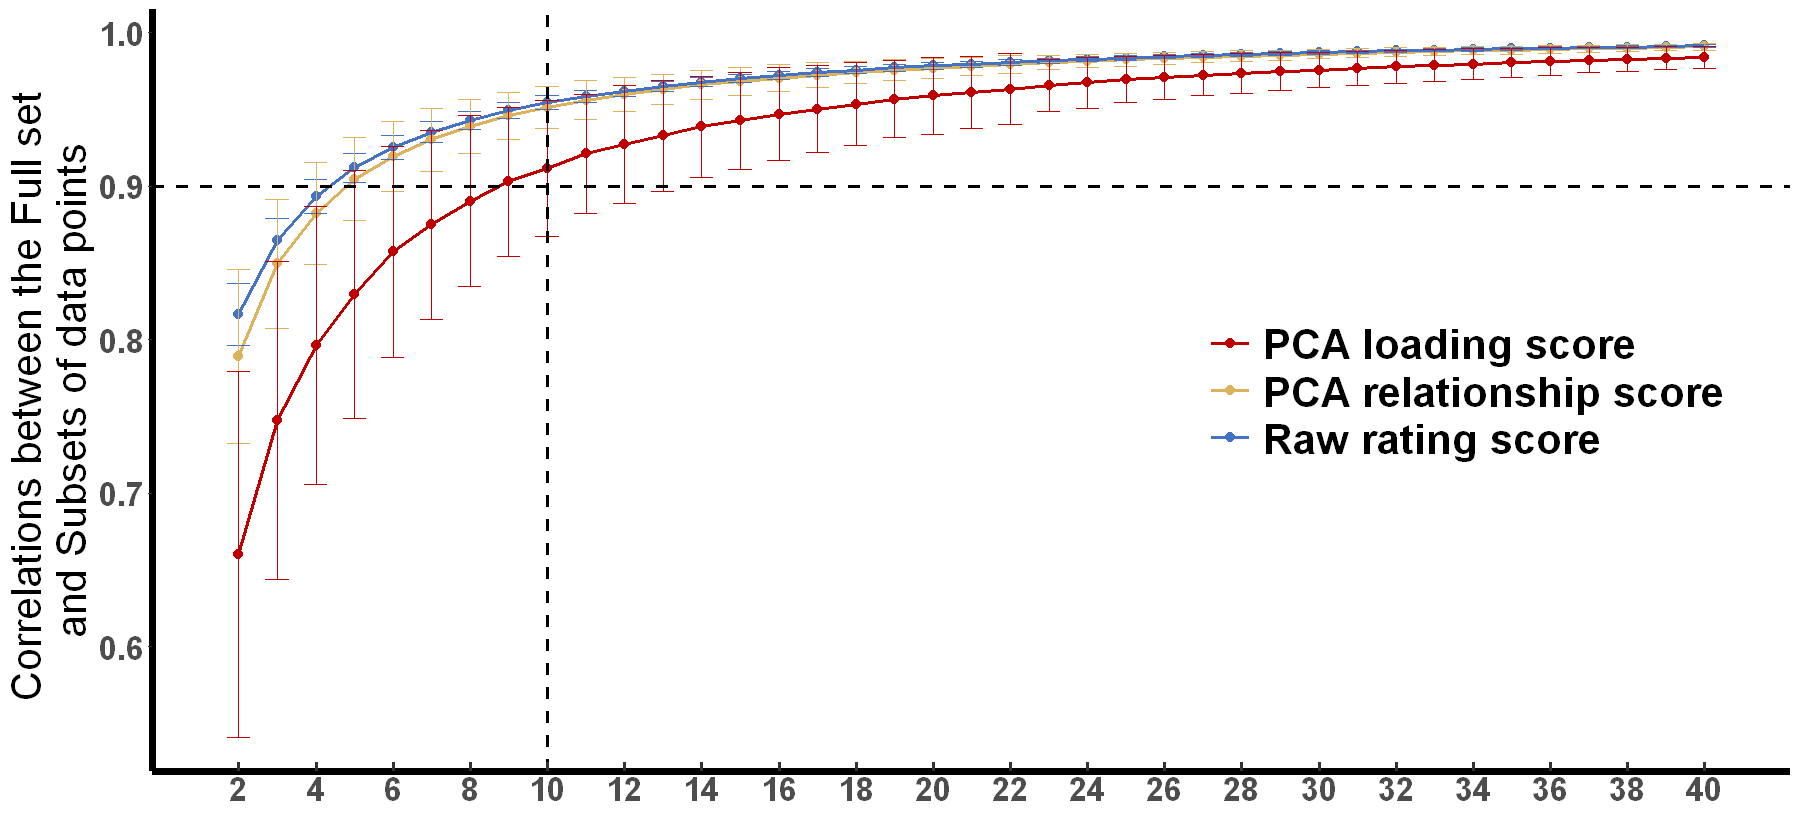

In [15]:
options(repr.plot.width = 15)
ggplot(mean_std_df,aes(x=step,y=mean,color=data,group=data))+
    geom_point(size=2.5)+
    geom_line(size=1)+
    geom_errorbar(aes(ymin = mean - 1*std, ymax = mean + 1*std), width = 0.6)+
    scale_x_continuous(name = '',breaks = seq(2,40,2))+
    scale_y_continuous(name = 'Correlations between the Full set \nand Subsets of data points')+
    scale_color_manual(values = c('Raw rating score'='#4472C4','PCA relationship score'='#dbb35d','PCA loading score'='#C00000'))+
    
    geom_hline(yintercept = 0.9,linetype=2,size=1)+
    geom_vline(xintercept = 10,linetype=2,size=1)+
    theme_classic()+
    theme(axis.line = element_line(linetype=1,color="black",size=2),
          axis.text = element_text(size=20,face='bold'),
          axis.ticks.length.x = unit(-0.2,'cm'),
          axis.ticks.x = element_line(size=1),
          axis.title.y = element_text(size=25),
          legend.position = c(0.8, 0.5),legend.title = element_blank(),
          legend.text = element_text(size = 25,face='bold'),
          legend.key.size = unit(1,'cm'))

In [16]:
png("output_graph/power_analysis.png", bg="transparent",
    family = 'sans',units='in',width=15,height=8,res=300)
ggplot(mean_std_df,aes(x=step,y=mean,color=data,group=data))+
    geom_point(size=2.5)+
    geom_line(size=1)+
    geom_errorbar(aes(ymin = mean - 1*std, ymax = mean + 1*std), width = 0.6)+
    scale_x_continuous(name = '',breaks = seq(2,40,2))+
    scale_y_continuous(name = 'Correlations between the Full set \nand Subsets of data points')+
    scale_color_manual(values = c('Raw rating score'='#4472C4','PCA relationship score'='#dbb35d','PCA loading score'='#C00000'))+
    
    geom_hline(yintercept = 0.9,linetype=2,size=1)+
    geom_vline(xintercept = 10,linetype=2,size=1)+
    theme_classic()+
    theme(axis.line = element_line(linetype=1,color="black",size=2),
          axis.text = element_text(size=20,face='bold'),
          axis.ticks.length.x = unit(-0.2,'cm'),
          axis.ticks.x = element_line(size=1),
          axis.title.y = element_text(size=25),
          legend.position = c(0.8, 0.5),legend.title = element_blank(),
          legend.text = element_text(size = 25,face='bold'),
          legend.key.size = unit(1,'cm'))
dev.off()

png 
  2